In [1]:
import os
import pickle
import sys
from glob import glob

import climlab
import fedrl_climate_envs
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import tqdm
import xarray as xr

In [2]:
BASE_DIR = "/gws/nopw/j04/ai4er/users/pn341/climate-rl-fedrl"
RECORDS_DIR = f"{BASE_DIR}/records"
DATASETS_DIR = f"{BASE_DIR}/datasets"
IMGS_DIR = f"{BASE_DIR}/results/imgs/"
NUM_STEPS = 200

sys.path.append(BASE_DIR)

In [3]:
fp_Ts = f"{DATASETS_DIR}/skt.sfc.mon.1981-2010.ltm.nc"
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"


def download_and_save_dataset(url, filepath, dataset_name):
    if not os.path.exists(filepath):
        print(f"Downloading {dataset_name} data ...")
        dataset = xr.open_dataset(url, decode_times=False)
        dataset.to_netcdf(filepath, format="NETCDF3_64BIT")
        print(f"{dataset_name} data saved to {filepath}")
    else:
        print(f"Loading {dataset_name} data ...")
        dataset = xr.open_dataset(
            filepath,
            decode_times=xr.coders.CFDatetimeCoder(use_cftime=True),
        )
    return dataset


ncep_Ts = download_and_save_dataset(
    ncep_url + "surface_gauss/skt.sfc.mon.1981-2010.ltm.nc",
    fp_Ts,
    "NCEP surface temperature",
).sortby("lat")

lat_ncep = ncep_Ts.lat
lon_ncep = ncep_Ts.lon
Ts_ncep_annual = ncep_Ts.skt.mean(dim=("lon", "time"))

climlab_ebm = climlab.EBM_annual(
    A=210, B=2, D=0.6, a0=0.354, a2=0.25, num_lat=96
)
climlab_ebm.Ts[:] = 50.0
Ts_ncep_annual = Ts_ncep_annual.interp(
    lat=climlab_ebm.lat, kwargs={"fill_value": "extrapolate"}
)
Ts_ncep_annual = np.array(Ts_ncep_annual)

for i in range(NUM_STEPS):
    climlab_ebm.step_forward()

Loading NCEP surface temperature data ...


In [4]:
import re


def extract_algo(dirname):
    match = re.search(r"inference_([a-z0-9]+)_torch", dirname)
    return match.group(1) if match else None


def get_record_fns(exp_id):
    record_fns = glob(f"{RECORDS_DIR}/inf*{exp_id}_*/*/*_{NUM_STEPS}.pth")
    record_fns = [
        fn
        for fn in record_fns
        if extract_algo(os.path.basename(os.path.dirname(fn))) in ALGOS
    ]
    return record_fns

In [5]:
from multiprocessing import Pool, cpu_count


def get_error_row(record_fn):
    with open(record_fn, "rb") as f:
        exp_id, algo = record_fn.split("/")[-3:-1]
        exp_id = exp_id.split("_")[1]
        seed = int(algo.split("__")[-2])
        algo = algo.split("__")[1].split("_")[1]

        record_steps = torch.load(f)
        ebm_state = record_steps["next_obs"][-1]
        error = Ts_ncep_annual - ebm_state

        return {
            "exp_id": exp_id,
            "algo": algo,
            "seed": seed,
            "error": error,
            "fn": record_fn,
        }


def get_error_rows(record_fns):
    with Pool(processes=cpu_count() - 2) as pool:
        results = list(
            tqdm.tqdm(
                pool.imap_unordered(get_error_row, record_fns),
                total=len(record_fns),
            )
        )
    return [row for row in results if row is not None]

In [6]:
EXPERIMENT_ID = "ebm-v1-homo-64L"
NUM_STEPS = 200
ALGOS = {"tqc", "td3", "ddpg"}

record_fns = get_record_fns(EXPERIMENT_ID)

df = pd.DataFrame(get_error_rows(record_fns))
df["error_mse"] = df["error"].apply(lambda x: np.mean(np.square(x)))
df.drop(columns=["error"], inplace=True)
df = df.sort_values("error_mse", ascending=True)
df.head(10)

100%|████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 590.69it/s]


,exp_id,algo,seed,fn,error_mse
5,ebm-v1-homo-64L,td3,1,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...,11.951201
8,ebm-v1-homo-64L,ddpg,5,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...,19.143118
4,ebm-v1-homo-64L,ddpg,6,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...,19.228419
2,ebm-v1-homo-64L,ddpg,9,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...,19.657146
0,ebm-v1-homo-64L,ddpg,1,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...,20.650744
13,ebm-v1-homo-64L,td3,5,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...,21.966533
27,ebm-v1-homo-64L,ddpg,2,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...,25.416486
25,ebm-v1-homo-64L,td3,9,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...,27.413562
3,ebm-v1-homo-64L,ddpg,4,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...,30.043178
29,ebm-v1-homo-64L,tqc,5,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...,30.456652


In [7]:
from base64 import b64encode

from IPython.display import HTML

video_path = (
    df.values[0][3]
    .replace("/records/", "/videos/")
    .replace(f"step_{NUM_STEPS}.pth", "rl-video-episode-0.mp4")
)
mp4 = open(video_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(
    f"""
<video width=1280 controls>
    <source src="{data_url}" type="video/mp4">
</video>
"""
)

In [8]:
from collections import defaultdict


def get_records(record_fns):
    records = defaultdict(dict)
    for record_fn in record_fns:
        error_row = get_error_row(record_fn)
        algo = error_row["algo"].lower()
        seed = int(error_row["seed"])
        error = error_row["error"]
        records[algo][seed] = error
    return records

In [9]:
def area_weighted_rmse(error, latitudes):
    weights = np.cos(np.radians(latitudes))
    weights /= weights.sum()
    return np.sqrt(np.average(error**2, weights=weights))


def plot_zonal_errors(records, exp_id):
    bins = [-90, -60, -30, 0, 30, 60, 90]
    labels = [
        "90°S–60°S",
        "60°S–30°S",
        "30°S–0°",
        "0°–30°N",
        "30°N–60°N",
        "60°N–90°N",
    ]
    x = np.arange(len(labels))
    width = 0.2

    error_climlab = Ts_ncep_annual - np.array(climlab_ebm.Ts).reshape(-1)
    climlab_means = []
    for i in range(len(bins) - 1):
        idx = (climlab_ebm.lat >= bins[i]) & (climlab_ebm.lat < bins[i + 1])
        climlab_means.append(
            area_weighted_rmse(error_climlab[idx], climlab_ebm.lat[idx])
        )

    plt.figure(figsize=((6.4, 4.8)))
    plt.bar(
        x + width * 1.5,
        climlab_means,
        width,
        label="CLIMLAB",
        color="gray",
        alpha=0.6,
    )

    offsets = dict(ddpg=-width * 1.5, td3=-width * 0.5, tqc=width * 0.5)

    for algo, seeds in records.items():
        zone_errors = []

        for seed, errors in seeds.items():
            zonal_means = []
            for i in range(len(bins) - 1):
                idx = (climlab_ebm.lat >= bins[i]) & (
                    climlab_ebm.lat < bins[i + 1]
                )
                zonal_means.append(
                    area_weighted_rmse(errors[idx], climlab_ebm.lat[idx])
                )
            zone_errors.append(zonal_means)

        zone_errors = np.array(zone_errors)
        mean = zone_errors.mean(axis=0)
        std = 1.96 * zone_errors.std(axis=0) / np.sqrt(10)
        best = zone_errors.min(axis=0)

        x_pos = x + offsets[algo]
        bars = plt.bar(
            x_pos,
            mean,
            width,
            label=f"{algo.upper()}",
            yerr=std,
            capsize=3,
            alpha=0.8,
        )

        for i in range(len(x)):
            plt.hlines(
                y=best[i],
                xmin=x_pos[i] - width / 2,
                xmax=x_pos[i] + width / 2,
                colors="white",
                linestyles="solid",
                linewidth=1,
                zorder=1,
            )
            plt.plot(
                x_pos[i],
                best[i],
                marker="x",
                color="black",
                markersize=4,
                zorder=5,
            )

    plt.xticks(x, labels)
    plt.title(exp_id)
    plt.xlabel("Latitude")
    plt.ylabel("Area Weighted RMSE (°C)")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    if "ebm-v1" in exp_id:
        plt.ylim(0, 20)
    elif "ebm-v0" in exp_id:
        plt.ylim(0, 45)
    plt.tight_layout()
    plt.savefig(
        f"{IMGS_DIR}/{exp_id}_areaWRMSE_zonal_errors.png",
        dpi=300,
        bbox_inches="tight",
    )

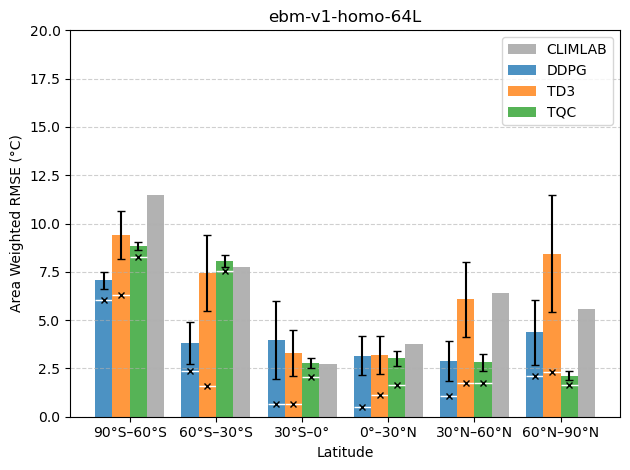

In [10]:
records = get_records(record_fns)
plot_zonal_errors(records, EXPERIMENT_ID)

100%|███████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:07<00:00,  1.08it/s]


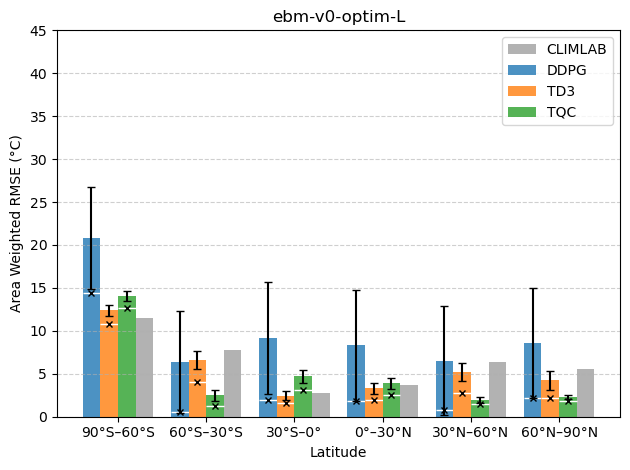

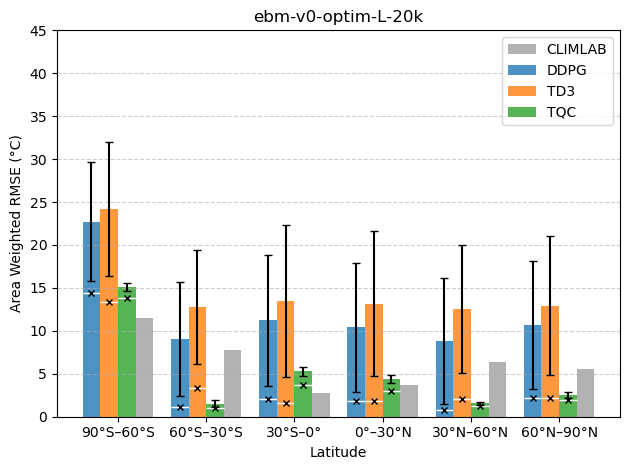

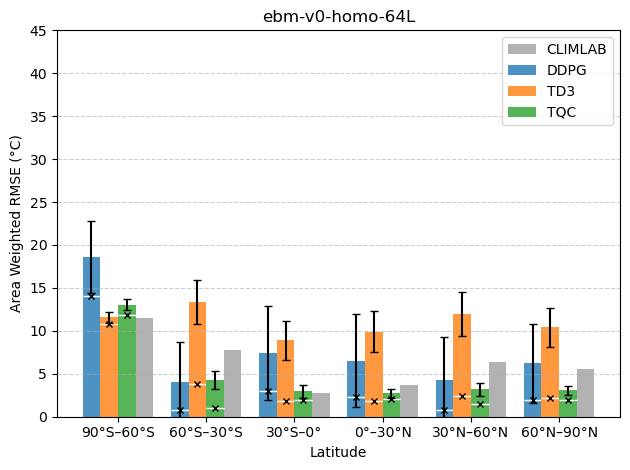

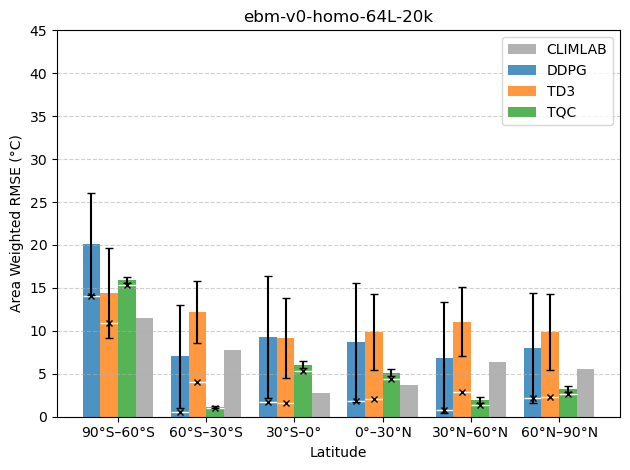

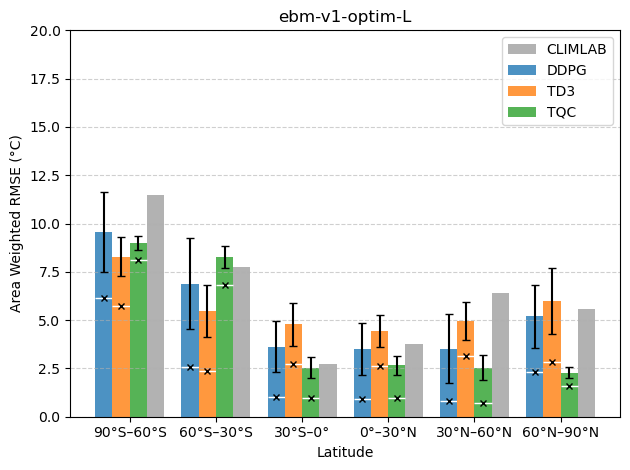

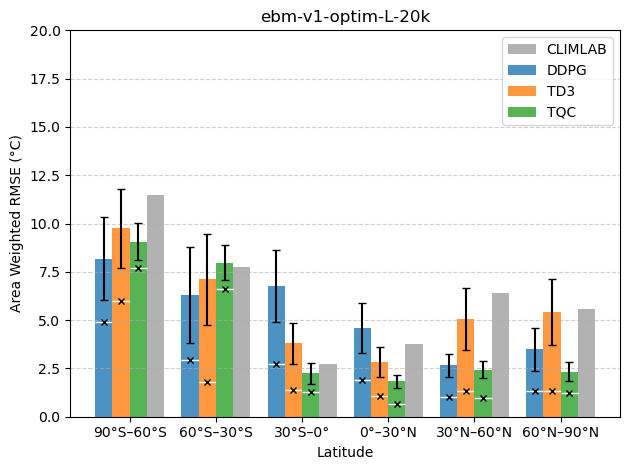

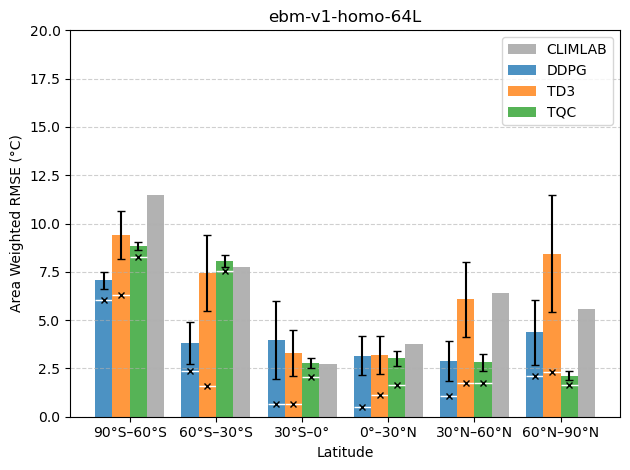

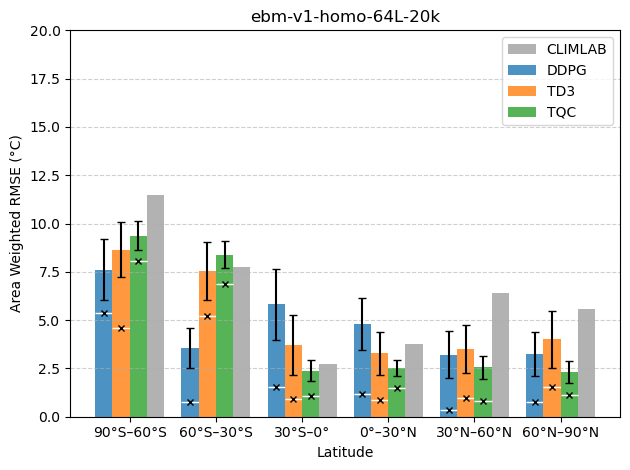

In [11]:
EXPERIMENT_IDS = [
    "ebm-v0-optim-L",
    "ebm-v0-optim-L-20k",
    "ebm-v0-homo-64L",
    "ebm-v0-homo-64L-20k",
    "ebm-v1-optim-L",
    "ebm-v1-optim-L-20k",
    "ebm-v1-homo-64L",
    "ebm-v1-homo-64L-20k",
]

for exp_id in tqdm.tqdm(EXPERIMENT_IDS):
    record_fns = get_record_fns(exp_id)
    records = get_records(record_fns)
    plot_zonal_errors(records, exp_id)